# Analyzing Continuous vs. Gravimetric PM2.5 Monitor Concentrations
# Brannon Seay, 2021-10-18

### An analysis of concentration differences between collocated Gravimetric and Continuous PM2.5 monitors across the United States using data from the U.S. EPA's Air Quality System (AQS). Various parameters will be explored that could help explain the differences (e.g., temperature) and a ML model is used to predict differences based on these factors.




# This notebook includes the following:
1. **Data Wrangling**

> gather

> assess

> clean

2. **Analyze**: Exploratory data analysis
3. **Implement**: ML Model implementation

Results and outcomes of this assessment are highlighted in a Medium blog post (https://brannonseay.medium.com/concentration-analysis-between-epas-continuous-and-gravimetric-pm2-5-monitor-cc806c108b41)

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
import requests
import json
import os
import itertools
from datetime import datetime

# Import Meteostat library and dependencies to gather meteorological data
# For more info on this library, see https://dev.meteostat.net/python/
# To install: pip install meteostat
from meteostat import Point, Daily

# Import ML model libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Plotting dependencies
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'font.size': 12})

### Wrangle: Gather data
> The AQS API (https://aqs.epa.gov/aqsweb/documents/data_api.html) is the primary place to obtain row-level data from the EPA's Air Quality System (AQS) database. You must sign up (https://aqs.epa.gov/aqsweb/documents/data_api.html#signup) to obtain a key to use the API.

In [2]:
# Critical API user inputs
email = 'your_email_here'
key = 'your_key_here'
parameter = '88101' # PM2.5
startdate = '20160101' # Want data from 2016-2020
enddate = '20201231'

In [3]:
# Pull state ID info, which will be used to query monitor data from every state
state_url = 'https://aqs.epa.gov/data/api/list/states?email='+email+'&key='+key
response = requests.get(state_url)
response # an output of 'Response [200]' indicates the download was successful!

<Response [200]>

In [4]:
# Load the states data dictionary
states_dict = json.loads(response.content)

# Convert dictionary to DataFrame and create a list of state codes which we'll use to loop through all API urls.
df_states = pd.DataFrame.from_dict(states_dict['Data'])
state_list = df_states['code'].tolist()
state_list

['01',
 '02',
 '04',
 '05',
 '06',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '53',
 '54',
 '55',
 '56',
 '66',
 '72',
 '78',
 '80',
 'CC']

### Monitors
#### Returns operational information about the samplers (monitors) used to collect the data. Includes identifying information, operational dates, operating organizations, etc.

In [5]:
# Loop through all states (and territories and other 'areas') and pull basic PM2.5 monitoring information
# 'State' list includes Mexico, Canada, Virgin Islands, Guam, and Puerto Rico, which we'll include in the analysis.
first = 0
for i in range(len(state_list)):
    monitor_url = 'https://aqs.epa.gov/data/api/monitors/byState?email='+email+'&key='+key+'&param='+parameter+'&bdate='+startdate+'&edate='+enddate+'&state='+state_list[i]
    response = requests.get(monitor_url)
    # If statement checks that response == <Response [200]>. Alternatively, could use if response.ok:, or a try/except might be best option
    if response.status_code == 200:
        dictt = json.loads(response.content)
        # Since empty strings are false in Python, the below if statement will only consider the
        # url pull for a given state if it actually contains monitor 'Data'.
        if dictt['Data']:
            # if this is the first set of data, create a new dataframe. Else, concatenate.
            if first == 0:
                df_monitors = pd.DataFrame.from_dict(dictt['Data'])
            else:
                df_monitors = pd.concat([df_monitors,pd.DataFrame.from_dict(dictt['Data'])])
            first += 1

In [6]:
# What does the monitor dataset look like
print(df_monitors.shape)
df_monitors.info()

(1957, 41)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957 entries, 0 to 3
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state_code               1957 non-null   object 
 1   county_code              1957 non-null   object 
 2   site_number              1957 non-null   object 
 3   parameter_code           1957 non-null   object 
 4   poc                      1957 non-null   int64  
 5   parameter_name           1957 non-null   object 
 6   open_date                1957 non-null   object 
 7   close_date               636 non-null    object 
 8   concurred_exclusions     122 non-null    object 
 9   dominant_source          1051 non-null   object 
 10  measurement_scale        1897 non-null   object 
 11  measurement_scale_def    1897 non-null   object 
 12  monitoring_objective     1957 non-null   object 
 13  last_method_code         1957 non-null   object 
 14  last_method_desc

In [8]:
# As long as this sum is zero (will depend on the startdate and enddate selected), we won't have to worry about 
# removing duplicates in the df_monitor and daily data merge step later on.
df_monitors.duplicated(subset=['state_code','county_code','site_number','poc']).sum()

0

In [9]:
# Save the monitor dataset
df_monitors.to_csv('monitor_data.csv',sep='|')

### AQS API: Daily Summary Data
#### Returns data summarized at the daily level. All daily summaries are calculated on midnight to midnight basis in local time. Variables returned include date, mean value, maximum value, etc. Data is at the monitor level and may Include more than one entry per monitor. There may be multiple entries for different (1) sample durations, (2) pollutant standards.

In [13]:
# Can only search daily data in one year increments, so make a list of years we want to query.
years = ['{:0.0f}'.format(v) for v in range(2016,2021,1)] # Creates a list of years as strings from whatever interval provided.

# Remove unneeded columns. Doing in loop rather than after as running into memory problems otherwise
del_col = ['datum','first_max_value','first_max_hour','aqi','method','local_site_name',
           'site_address','state','county','city','cbsa_code','cbsa','date_of_last_change']

# Will change the following object columns to categorical to further help w/ memory issue
to_cat = ['state_code','county_code','site_number','parameter_code','parameter','sample_duration',
          'pollutant_standard','date_local','units_of_measure','event_type','validity_indicator','method_code']

# Loop through each year and all states (and territories and other 'areas'), pulling PM2.5 daily concentration data
first = 0
for yr in years:
    for state in state_list:
        conc_url = 'https://aqs.epa.gov/data/api/dailyData/byState?email='+email+'&key='+key+'&param='+parameter+'&bdate='+yr+'0101'+'&edate='+yr+'1231'+'&state='+state
        response = requests.get(conc_url)
        # If statement checks that response == <Response [200]>. Alternatively, could use if response.ok:, or a try/except might be best option
        if response.status_code == 200:
            dictt = json.loads(response.content)
            # Since empty strings are false in Python, the below if statement will only consider the
            # url pull for a given state if it actually contains monitor 'Data'.
            if dictt['Data']:
                # if this is the first set of data, create a new dataframe. Else, concatenate.
                if first == 0:
                    df_concs = pd.DataFrame.from_dict(dictt['Data'])
                    # Drop columns and change datatypes
                    df_concs.drop(axis=1, columns=del_col, inplace=True)
                    df_concs[to_cat] = df_concs[to_cat].astype('category')
                else:
                    df_concs = pd.concat([df_concs,pd.DataFrame.from_dict(dictt['Data'])])
                    # Drop columns and change datatypes
                    df_concs.drop(axis=1, columns=del_col, inplace=True)
                    df_concs[to_cat] = df_concs[to_cat].astype('category')                    
                first += 1
    # Remove the multiple entries for the different sample durations and pollutant standards            
    df_concs.drop_duplicates(subset=['state_code','county_code','site_number','parameter_code','poc','date_local'],inplace=True)

In [14]:
#Save the concentration dataset
df_concs.to_csv('daily_data_2016_20.csv',sep='|')

In [16]:
df_concs.shape

(1464416, 18)

In [17]:
df_concs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464416 entries, 0 to 3798
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   state_code           1464416 non-null  category
 1   county_code          1464416 non-null  category
 2   site_number          1464416 non-null  category
 3   parameter_code       1464416 non-null  category
 4   poc                  1464416 non-null  int64   
 5   latitude             1464416 non-null  float64 
 6   longitude            1464416 non-null  float64 
 7   parameter            1464416 non-null  category
 8   sample_duration      1464416 non-null  category
 9   pollutant_standard   878239 non-null   category
 10  date_local           1464416 non-null  category
 11  units_of_measure     1464416 non-null  category
 12  event_type           1464416 non-null  category
 13  observation_count    1464416 non-null  int64   
 14  observation_percent  1464416 non-null

In [10]:
# Make a copy of the newly created dataframe
df_copy = df_concs.copy()

# Add an AQS ID column
df_copy['aqs_id'] = df_copy.state_code.astype(str) + '-' + df_copy.county_code.astype(str) + '-' + df_copy.site_number.astype(str)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464416 entries, 0 to 1464415
Data columns (total 19 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   state_code           1464416 non-null  category
 1   county_code          1464416 non-null  category
 2   site_number          1464416 non-null  category
 3   parameter_code       1464416 non-null  category
 4   poc                  1464416 non-null  int64   
 5   latitude             1464416 non-null  float64 
 6   longitude            1464416 non-null  float64 
 7   parameter            1464416 non-null  category
 8   sample_duration      1464416 non-null  category
 9   pollutant_standard   878239 non-null   category
 10  date_local           1464416 non-null  category
 11  units_of_measure     1464416 non-null  category
 12  event_type           1464416 non-null  category
 13  observation_count    1464416 non-null  int64   
 14  observation_percent  1464416 non-n

In [12]:
# How many measurements were invalidated
df_copy.validity_indicator.value_counts()

Y    1443624
N      20792
Name: validity_indicator, dtype: int64

In [13]:
# Remove invalide rows from dataframe
df_copy = df_copy[df_copy['validity_indicator'] != 'N']
df_copy.validity_indicator.value_counts()

Y    1443624
N          0
Name: validity_indicator, dtype: int64

In [14]:
# Merge the monitor data and daily conc data into single dataframe

# First, convert the state/county/site object columns in df_monitors to categorical to match that in df_copy
df_monitors['state_code'] = df_monitors.state_code.astype('category')
df_monitors['county_code'] = df_monitors.county_code.astype('category')
df_monitors['site_number'] = df_monitors.site_number.astype('category')

df_merge = pd.merge(df_copy,df_monitors, how='left',
                    left_on=['state_code','county_code','site_number','poc'],
                    right_on=['state_code','county_code','site_number','poc'],
                    validate='many_to_many')
df_merge.sample()

,state_code,county_code,site_number,parameter_code_x,poc,latitude_x,longitude_x,parameter,sample_duration,pollutant_standard,...,address,state_name,county_name,city_name,cbsa_code,cbsa_name,csa_code,csa_name,tribal_code,tribe_name
459699,42,077,0004,88101,3,40.611944,-75.4325,PM2.5 - Local Conditions,24-HR BLK AVG,PM25 Annual 1997,...,STATE HOSPITAL REAR 1600 HANOVER AVE,Pennsylvania,Lehigh,Allentown,10900,"Allentown-Bethlehem-Easton, PA-NJ",408,"New York-Newark, NY-NJ-CT-PA",None,None


In [15]:
# May have some duplicates, if a monitor during the time period selected closed/opened.
# If sum here is zero, we are good to go.
df_merge.duplicated(subset=['state_code','county_code','site_number','poc','date_local']).sum()

0

In [16]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443624 entries, 0 to 1443623
Data columns (total 56 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   state_code               1443624 non-null  category
 1   county_code              1443624 non-null  category
 2   site_number              1443624 non-null  object  
 3   parameter_code_x         1443624 non-null  category
 4   poc                      1443624 non-null  int64   
 5   latitude_x               1443624 non-null  float64 
 6   longitude_x              1443624 non-null  float64 
 7   parameter                1443624 non-null  category
 8   sample_duration          1443624 non-null  category
 9   pollutant_standard       878239 non-null   category
 10  date_local               1443624 non-null  category
 11  units_of_measure         1443624 non-null  category
 12  event_type               1443624 non-null  category
 13  observation_count        14

In [17]:
# To pair the collocated samples, we will pivot the merged dataframe
df_pairs = df_merge.pivot(index = ['aqs_id','date_local','latitude_x','longitude_x','elevation','dominant_source',
                                   'measurement_scale','monitoring_objective'],
                          columns = ['poc'],
                          values = ['arithmetic_mean','method_code','monitor_type','probe_height','pl_probe_location'])
print(df_pairs.shape)
df_pairs.head(3)

(1283101, 60)


arithmetic_mean  \
poc                                                                                                                         1    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective                   
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE              7.9   
            2016-01-04 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE              5.3   
            2016-01-07 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE              6.7   

                                                                                                                     \
poc                                                                                                              2    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-04 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-07 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   

                                                                                                                     \
poc                                                                                                              3    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-04 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-07 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   

                                                                                                                     \
poc                                                                                                              4    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-04 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-07 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   

                                                                                                                     \
poc                                                                                                              5    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-04 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-07 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   NaN   

                                                                                                                     \
poc                                                                                                              6    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-003-0010 2016-01-01 30.497478  -87.880258  37.19     POINT           NEIGHBORHOOD      POPULATION EXPOSURE   N

In [18]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1283101 entries, ('01-003-0010', '2016-01-01', 30.497478, -87.880258, 37.19, 'POINT', 'NEIGHBORHOOD', 'POPULATION EXPOSURE') to ('80-002-0014', '2020-12-31', 32.633671, -115.504995, 0.0, 'AREA', 'REGIONAL SCALE', 'REGIONAL TRANSPORT')
Data columns (total 60 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   (arithmetic_mean, 1)     506073 non-null  object
 1   (arithmetic_mean, 2)     88767 non-null   object
 2   (arithmetic_mean, 3)     682115 non-null  object
 3   (arithmetic_mean, 4)     86722 non-null   object
 4   (arithmetic_mean, 5)     40873 non-null   object
 5   (arithmetic_mean, 6)     8502 non-null    object
 6   (arithmetic_mean, 7)     19724 non-null   object
 7   (arithmetic_mean, 8)     3161 non-null    object
 8   (arithmetic_mean, 9)     4260 non-null    object
 9   (arithmetic_mean, 11)    2815 non-null    object
 10  (arithmetic_mean, 21)    552 

In [19]:
# Remove any row from the pivoted table (df_pairs) in which there is only one value, since this site/date doesn't have collocated sampler results.
# non_dups is a series summing the number of samplers located at a given site/date
non_dups = (~df_pairs.arithmetic_mean.isnull()).sum(axis=1)
non_dups

aqs_id       date_local  latitude_x  longitude_x  elevation  dominant_source  measurement_scale  monitoring_objective
01-003-0010  2016-01-01  30.497478   -87.880258   37.19      POINT            NEIGHBORHOOD       POPULATION EXPOSURE     1
             2016-01-04  30.497478   -87.880258   37.19      POINT            NEIGHBORHOOD       POPULATION EXPOSURE     1
             2016-01-07  30.497478   -87.880258   37.19      POINT            NEIGHBORHOOD       POPULATION EXPOSURE     1
             2016-01-10  30.497478   -87.880258   37.19      POINT            NEIGHBORHOOD       POPULATION EXPOSURE     1
             2016-01-13  30.497478   -87.880258   37.19      POINT            NEIGHBORHOOD       POPULATION EXPOSURE     1
                                                                                                                        ..
80-002-0014  2020-12-27  32.633671   -115.504995  0.00       AREA             REGIONAL SCALE     REGIONAL TRANSPORT      1
             2020-12-

In [20]:
non_dups.value_counts()

1    1142075
2     123760
3      15121
4       2059
5         86
dtype: int64

#### From the above we see that the majority of site/date include only a single concentration record. Will drop these rows.

In [21]:
# Let's drop rows with only one monitor, i.e, non_dups == 1
index_to_drop = df_pairs[non_dups==1].index
coll_only = df_pairs.drop(index_to_drop)
print(coll_only.shape)
coll_only.head()

(141026, 60)


arithmetic_mean  \
poc                                                                                                                                               1    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective                                         
01-073-0023 2016-01-01 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE            11.6   
            2016-01-04 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE             7.8   
            2016-01-07 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE             7.3   
            2016-01-10 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE             2.4   
            2016-01-13 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE            10.6   

                                                                                                                                           \
poc                                                                                                                                    2    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective                              
01-073-0023 2016-01-01 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   
            2016-01-04 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   
            2016-01-07 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   
            2016-01-10 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   
            2016-01-13 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   

                                                                                                                                           \
poc                                                                                                                                    3    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective                              
01-073-0023 2016-01-01 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  8.8   
            2016-01-04 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  6.6   
            2016-01-07 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  7.9   
            2016-01-10 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  1.9   
            2016-01-13 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  9.1   

                                                                                                                                           \
poc                                                                                                                                    4    
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective                              
01-073-0023 2016-01-01 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGHEST CONCENTRATION; POPULATION EXPOSURE  NaN   
            2016-01-04 33.553056  -86.815     177.0     POINT           NEIGHBORHOOD      HIGH

In [22]:
# Are monitor_type, probe_height, and pl_probe_location unique per POC or site?
# Check for duplicates in monitor_type.
# Values > 1 in the below series (mon_type_diff) indicate differences across POCs at a given site
mon_type_diff = coll_only.monitor_type.apply(lambda x: len(x[:].value_counts()),axis=1)
print(mon_type_diff.value_counts())
coll_only['monitor_type'][mon_type_diff.values > 1]

1    116674
2     12710
0     11642
dtype: int64


poc                                                                                                                1   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective          
01-103-0011 2020-08-01 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SLAMS   
            2020-08-04 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SLAMS   
            2020-08-07 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SLAMS   
            2020-08-10 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SLAMS   
            2020-08-13 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SLAMS   
...                                                                                                               ...   
54-039-0020 2020-12-17 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SLAMS   
            2020-12-20 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SLAMS   
            2020-12-23 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SLAMS   
            2020-12-26 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SLAMS   
            2020-12-29 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SLAMS   

poc                                                                                                              2   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-103-0011 2020-08-01 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   NaN   
            2020-08-04 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   NaN   
            2020-08-07 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   NaN   
            2020-08-10 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   NaN   
            2020-08-13 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   NaN   
...                                                                                                             ...   
54-039-0020 2020-12-17 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SPM   
            2020-12-20 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SPM   
            2020-12-23 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SPM   
            2020-12-26 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SPM   
            2020-12-29 38.346258  -81.621161  223.11    AREA            URBAN SCALE       POPULATION EXPOSURE   SPM   

poc                                                                                                              3   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
01-103-0011 2020-08-01 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SPM   
            2020-08-04 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SPM   
            2020-08-07 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SPM   
            2020-08-10 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SPM   
            2020-08-13 34.530717  -86.967536  173.74    AREA            MIDDLE SCALE      POPULATION EXPOSURE   SPM   
...                                          

In [23]:
# Now check for probe_height
# Check for duplicates in probe_height.
# Values > 1 in the below series (probe_ht_diff) indicate differences across POCs at a given site
probe_ht_diff = coll_only.probe_height.apply(lambda x: len(x[:].value_counts()),axis=1)
print(probe_ht_diff.value_counts())
coll_only['probe_height'][probe_ht_diff.values > 1]

1    84792
2    35859
0    19854
3      521
dtype: int64


poc                                                                                                               1   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective         
02-110-0004 2016-01-01 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE    6.0   
            2016-01-07 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE    6.0   
            2016-01-13 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE    6.0   
            2016-01-19 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE    6.0   
            2016-01-25 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE    6.0   
...                                                                                                              ...   
55-111-0007 2018-03-03 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    5.64   
            2018-03-09 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    5.64   
            2018-03-15 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    5.64   
            2018-03-21 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    5.64   
            2018-03-27 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    5.64   

poc                                                                                                              2   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
02-110-0004 2016-01-01 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-07 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-13 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-19 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
            2016-01-25 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   NaN   
...                                                                                                             ...   
55-111-0007 2018-03-03 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    NaN   
            2018-03-09 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    NaN   
            2018-03-15 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    NaN   
            2018-03-21 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    NaN   
            2018-03-27 43.435100  -89.679790  392.0     AREA            REGIONAL SCALE    GENERAL/BACKGROUND    NaN   

poc                                                                                                              3   \
aqs_id      date_local latitude_x longitude_x elevation dominant_source measurement_scale monitoring_objective        
02-110-0004 2016-01-01 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   8.0   
            2016-01-07 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   8.0   
            2016-01-13 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   8.0   
            2016-01-19 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   8.0   
            2016-01-25 58.388497  -134.567237 15.0      AREA            NEIGHBORHOOD      POPULATION EXPOSURE   8.0   
...                                                       

In [ ]:
# Now check for pl_probe_location
# Check for duplicates in pl_probe_location.
# Values > 1 in the below series (probe_loc_diff) indicate differences across POCs at a given site
probe_loc_diff = coll_only.pl_probe_location.apply(lambda x: len(x[:].value_counts()),axis=1)
print(probe_loc_diff.value_counts())
coll_only['pl_probe_location'][probe_loc_diff.values > 1]

#### Recap on monitor_type, probe_height, and pl_probe_location being different for monitors at same location
> **monitor_type**: differences here are not concerning and actually expected. It would be surprising if this parameter provides much help in analyzing concentration differences, but will still investigate.

> **probe_height**: it is expected that collocated monitors have probe heights w/in 1 meter of each other. Anything greater should be closely scrutinized. Height difference could potentially impact concentration differences.

> **pl_probe_location**: results should be closely scrutinized if these are not at same location, e.g., one at 'ground level support' and other at 'top of building'.

In [24]:
# Let's clean up the column/index in our dataframe

# reset the index, making new columns.
collocate = coll_only.reset_index()

# Need the date to be of datetime format rather than a string.
collocate['date_local'] = pd.to_datetime(collocate['date_local'])

# Create a list of strings containing cleaned column names
col_names = collocate.columns.tolist()
col_names_str = ['{}'.format(v) for v in col_names]
col_names_str = [s.replace("('",'') for s in col_names_str]
col_names_str = [s.replace("', '')",'') for s in col_names_str]
col_names_str = [s.replace("', ",'_') for s in col_names_str]
col_names_str = [s.replace(")",'') for s in col_names_str]
col_names_str

# Drop one of the column levels of our df
collocate.columns = collocate.columns.droplevel(1)

# Replace column names
collocate.columns = col_names_str

collocate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141026 entries, 0 to 141025
Data columns (total 68 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                141026 non-null  object        
 1   date_local            141026 non-null  datetime64[ns]
 2   latitude_x            141026 non-null  float64       
 3   longitude_x           141026 non-null  float64       
 4   elevation             141026 non-null  float64       
 5   dominant_source       73071 non-null   object        
 6   measurement_scale     137091 non-null  object        
 7   monitoring_objective  141026 non-null  object        
 8   arithmetic_mean_1     109976 non-null  object        
 9   arithmetic_mean_2     36398 non-null   object        
 10  arithmetic_mean_3     98239 non-null   object        
 11  arithmetic_mean_4     36276 non-null   object        
 12  arithmetic_mean_5     10228 non-null   object        
 13 

In [25]:
# Drop the *_33 columns, as these are all nulls
collocate.drop(axis=1,columns=['arithmetic_mean_33','method_code_33','monitor_type_33','probe_height_33','pl_probe_location_33'],inplace=True)
collocate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141026 entries, 0 to 141025
Data columns (total 63 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                141026 non-null  object        
 1   date_local            141026 non-null  datetime64[ns]
 2   latitude_x            141026 non-null  float64       
 3   longitude_x           141026 non-null  float64       
 4   elevation             141026 non-null  float64       
 5   dominant_source       73071 non-null   object        
 6   measurement_scale     137091 non-null  object        
 7   monitoring_objective  141026 non-null  object        
 8   arithmetic_mean_1     109976 non-null  object        
 9   arithmetic_mean_2     36398 non-null   object        
 10  arithmetic_mean_3     98239 non-null   object        
 11  arithmetic_mean_4     36276 non-null   object        
 12  arithmetic_mean_5     10228 non-null   object        
 13 

In [26]:
# Save this dataset
collocate.to_csv('collocate.csv',sep='|',index=False)

### Still on the Wrange/Gather stage:
#### Pull MET data based on our collocated site lat/lon.

In [40]:
# Loop through the collocation dataframe, pulling MET data from Meteostat provided the lat/lon/elevation/date
for row in range(collocate.shape[0]):
    # date
    start = collocate.date_local[row]
    # only seeking a single day's worth of data, so end date = start date
    end = start
    # Get the point location data for the lat/lon and elevation
    # TODO: confirm units for the elevation from both EPA and Meteostat
    location = Point(collocate.latitude_x[row], collocate.longitude_x[row], collocate.elevation[row]) 
    
    data = Daily(location, start, end).fetch()
    
    # if no data were pulled created a row of nans to concatenate to df
    if data.shape[0] == 0:
        data.loc[data.shape[0]] = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]

    if row == 0:
        met_df = data
    else:
        met_df = pd.concat([met_df, data])

#### Not all location/date data were extractable, as noted by the warnings above.

In [41]:
# Save the MET data
met_df.to_csv('met_data_2016_20.csv',sep='|')

In [29]:
met_df.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,122706.000000,123301.000000,123298.000000,100281.000000,74371.000000,58007.000000,121232.000000,444.000000,102441.000000,2174.000000
mean,13.718591,8.312973,19.386718,2.272223,10.539605,197.546156,11.456224,68.403153,1016.902275,378.033579
std,10.419029,10.207660,11.251939,7.637921,56.063771,102.546579,6.074119,64.599093,6.905426,285.646825
min,-39.700000,-43.200000,-36.600000,0.000000,0.000000,0.000000,0.000000,0.000000,976.200000,0.000000
25%,6.000000,0.900000,11.100000,0.000000,0.000000,118.100000,7.100000,32.000000,1012.500000,60.000000
50%,14.800000,9.000000,20.900000,0.000000,0.000000,208.500000,10.400000,45.000000,1016.500000,411.500000
75%,22.500000,16.700000,28.500000,0.300000,0.000000,286.300000,14.800000,118.800000,1020.900000,614.000000
max,41.700000,34.900000,49.900000,381.000000,2540.000000,360.000000,53.300000,273.600000,1046.700000,980.000000


In [31]:
# Concatenate the concentration data w/ MET data
full_data_set = pd.concat([collocate,met_df],axis=1)
full_data_set

,aqs_id,date_local,latitude_x,longitude_x,elevation,dominant_source,measurement_scale,monitoring_objective,arithmetic_mean_1,arithmetic_mean_2,...,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,01-073-0023,2016-01-01,33.553056,-86.815000,177.0,POINT,NEIGHBORHOOD,HIGHEST CONCENTRATION; POPULATION EXPOSURE,11.6,NaN,...,4.3,1.8,6.2,0.0,0.0,347.0,13.7,NaN,1027.1,NaN
1,01-073-0023,2016-01-04,33.553056,-86.815000,177.0,POINT,NEIGHBORHOOD,HIGHEST CONCENTRATION; POPULATION EXPOSURE,7.8,NaN,...,3.4,-0.9,6.2,0.0,0.0,NaN,18.4,NaN,1025.3,NaN
2,01-073-0023,2016-01-07,33.553056,-86.815000,177.0,POINT,NEIGHBORHOOD,HIGHEST CONCENTRATION; POPULATION EXPOSURE,7.3,NaN,...,7.6,3.4,12.9,0.3,0.0,NaN,9.4,NaN,1019.0,NaN
3,01-073-0023,2016-01-10,33.553056,-86.815000,177.0,POINT,NEIGHBORHOOD,HIGHEST CONCENTRATION; POPULATION EXPOSURE,2.4,NaN,...,5.3,-3.7,8.4,0.0,0.0,296.2,17.6,NaN,NaN,NaN
4,01-073-0023,2016-01-13,33.553056,-86.815000,177.0,POINT,NEIGHBORHOOD,HIGHEST CONCENTRATION; POPULATION EXPOSURE,10.6,NaN,...,4.9,-2.0,11.8,0.0,0.0,NaN,3.2,NaN,1024.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141021,80-002-0012,2020-12-27,32.629225,-115.447769,1.0,NaN,NaN,GENERAL/BACKGROUND,NaN,NaN,...,13.0,6.0,21.6,0.0,NaN,NaN,4.7,NaN,1013.0,NaN
141022,80-002-0012,2020-12-28,32.629225,-115.447769,1.0,NaN,NaN,GENERAL/BACKGROUND,NaN,NaN,...,14.9,12.7,18.2,0.0,NaN,284.5,26.2,NaN,1011.1,NaN
141023,80-002-0012,2020-12-29,32.629225,-115.447769,1.0,NaN,NaN,GENERAL/BACKGROUND,NaN,NaN,...,12.0,6.6,17.7,0.0,NaN,323.1,11.4,NaN,1017.9,NaN
141024,80-002-0012,2020-12-30,32.629225,-115.447769,1.0,NaN,NaN,GENERAL/BACKGROUND,NaN,NaN,...,10.8,2.1,19.3,0.0,NaN,NaN,8.6,NaN,1021.4,NaN


In [32]:
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141026 entries, 0 to 141025
Data columns (total 74 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                141026 non-null  object        
 1   date_local            141026 non-null  datetime64[ns]
 2   latitude_x            141026 non-null  float64       
 3   longitude_x           141026 non-null  float64       
 4   elevation             141026 non-null  float64       
 5   dominant_source       73071 non-null   object        
 6   measurement_scale     137091 non-null  object        
 7   monitoring_objective  141026 non-null  object        
 8   arithmetic_mean_1     109976 non-null  object        
 9   arithmetic_mean_2     36398 non-null   object        
 10  arithmetic_mean_3     98239 non-null   object        
 11  arithmetic_mean_4     36276 non-null   object        
 12  arithmetic_mean_5     10228 non-null   object        
 13 

In [40]:
full_data_set.columns

Index(['aqs_id', 'date_local', 'latitude_x', 'longitude_x', 'elevation',
       'dominant_source', 'measurement_scale', 'monitoring_objective',
       'arithmetic_mean_1', 'arithmetic_mean_2', 'arithmetic_mean_3',
       'arithmetic_mean_4', 'arithmetic_mean_5', 'arithmetic_mean_6',
       'arithmetic_mean_7', 'arithmetic_mean_8', 'arithmetic_mean_9',
       'arithmetic_mean_11', 'arithmetic_mean_21', 'method_code_1',
       'method_code_2', 'method_code_3', 'method_code_4', 'method_code_5',
       'method_code_6', 'method_code_7', 'method_code_8', 'method_code_9',
       'method_code_11', 'method_code_21', 'monitor_type_1', 'monitor_type_2',
       'monitor_type_3', 'monitor_type_4', 'monitor_type_5', 'monitor_type_6',
       'monitor_type_7', 'monitor_type_8', 'monitor_type_9', 'monitor_type_11',
       'monitor_type_21', 'probe_height_1', 'probe_height_2', 'probe_height_3',
       'probe_height_4', 'probe_height_5', 'probe_height_6', 'probe_height_7',
       'probe_height_8', 'probe

In [76]:
# Create a dataframe that includes pairs of each poc combination from full_data_set
params_1 = ['aqs_id', 'date_local', 'latitude_x', 'longitude_x', 'elevation','dominant_source',
            'measurement_scale', 'monitoring_objective','tavg', 'tmin', 'tmax', 'prcp', 'snow',
            'wdir', 'wspd', 'wpgt','pres', 'tsun']
params = ['arithmetic_mean_','method_code_','monitor_type_','probe_height_','pl_probe_location_']
pocs = ['1','2','3','4','5','6','7','8','9','11','21']
all_combos = list(itertools.combinations(pocs,2))

new_df = 0
# turn off SettingWithCopyWarning for this loop, as it doesn't apply here. Will turn back on after
pd.options.mode.chained_assignment = None  # default='warn'

for poc in all_combos:
    temp_df = full_data_set[params_1]
    temp_df['poc_a'] = poc[0]
    temp_df['poc_b'] = poc[1]
    for par in params:
        temp_df[par+'a'] = full_data_set[par+poc[0]]
        temp_df[par+'b'] = full_data_set[par+poc[1]]
        
    no_dups = (temp_df[['arithmetic_mean_a','arithmetic_mean_b']].isna()).sum(axis=1)
    index_to_drop = temp_df[no_dups != 0].index
    temp_df.drop(index_to_drop,inplace=True)
    
    if new_df == 0:
        df_paired = temp_df.copy()
    else:
        df_paired = pd.concat([df_paired,temp_df])
    new_df += 1

df_paired.reset_index(inplace=True,drop=True)
pd.options.mode.chained_assignment = 'warn'

In [77]:
df_paired.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182337 entries, 0 to 182336
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                182337 non-null  object        
 1   date_local            182337 non-null  datetime64[ns]
 2   latitude_x            182337 non-null  float64       
 3   longitude_x           182337 non-null  float64       
 4   elevation             182337 non-null  float64       
 5   dominant_source       97817 non-null   object        
 6   measurement_scale     178402 non-null  object        
 7   monitoring_objective  182337 non-null  object        
 8   tavg                  156789 non-null  float64       
 9   tmin                  157384 non-null  float64       
 10  tmax                  157381 non-null  float64       
 11  prcp                  129357 non-null  float64       
 12  snow                  95463 non-null   float64       
 13 

#### Now we have two columns each of data from the collocated monitors.

### Last data to gather and add here are the identifications of each method code as an FRM or FEM monitor
#### These data can be downloaded from here: https://aqs.epa.gov/aqsweb/documents/codetables/methods_all.html
#### I've downloaded to local machine and will import here w/ Pandas

In [80]:
# Import the method code dataset
meth_type = pd.read_csv('methods_all.csv')
meth_type.sample()

,Parameter,Parameter Code,Method Code,Recording Mode,Collection Description,Analysis Description,Method Type,Reference Method ID,Equivalent Method,Federal MDL,Min Value,Max Value,Digits,Round Truncate Indicator,Units
1188,2-Methyl-2-butene,43228,229,Continuous,preconcentrator trap/thermal desorber - Nafion...,PerkinElmer auto-GC dual FID – individual comp...,NaN,NaN,NaN,0.5,-1.0,1000.0,4,R,Parts per billion Carbon


In [81]:
# We only care about methods when parameter code = 88101 (PM2.5) and columns Method Code and 'Method Type'
meth_type_less = meth_type[meth_type['Parameter Code'] == 88101][['Method Code','Method Type']]
meth_type_less.reset_index(inplace=True,drop=True)
meth_type_less.sample(3)

,Method Code,Method Type
36,581,FEM
33,245,FRM
25,203,FEM


In [84]:
# Merge the method type for both method_code_a and method_code_b
df_final = df_paired.merge(meth_type_less,how='left',left_on='method_code_a',right_on='Method Code')
df_final.drop(columns='Method Code',inplace=True)
df_final.rename(columns={'Method Type':'meth_type_a'},inplace=True)
df_final = df_final.merge(meth_type_less,how='left',left_on='method_code_b',right_on='Method Code')
df_final.drop(columns='Method Code',inplace=True)
df_final.rename(columns={'Method Type':'meth_type_b'},inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182337 entries, 0 to 182336
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                182337 non-null  object        
 1   date_local            182337 non-null  datetime64[ns]
 2   latitude_x            182337 non-null  float64       
 3   longitude_x           182337 non-null  float64       
 4   elevation             182337 non-null  float64       
 5   dominant_source       97817 non-null   object        
 6   measurement_scale     178402 non-null  object        
 7   monitoring_objective  182337 non-null  object        
 8   tavg                  156789 non-null  float64       
 9   tmin                  157384 non-null  float64       
 10  tmax                  157381 non-null  float64       
 11  prcp                  129357 non-null  float64       
 12  snow                  95463 non-null   float64       
 13 

### Since our main goal is to analyze FRM vs FEM monitors, will filter dataframe to only when we have this comparison and set all FRMs and FEMs to given columns

In [96]:
# Create two separate dataframes, one where _a are FRMs and _b are FEMs, and vice versa
df_a = df_final.query('(meth_type_a == "FRM" & meth_type_b == "FEM")')
df_b = df_final.query('(meth_type_b == "FRM" & meth_type_a == "FEM")')
df_b.columns

Index(['aqs_id', 'date_local', 'latitude_x', 'longitude_x', 'elevation',
       'dominant_source', 'measurement_scale', 'monitoring_objective', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
       'poc_a', 'poc_b', 'arithmetic_mean_a', 'arithmetic_mean_b',
       'method_code_a', 'method_code_b', 'monitor_type_a', 'monitor_type_b',
       'probe_height_a', 'probe_height_b', 'pl_probe_location_a',
       'pl_probe_location_b', 'meth_type_a', 'meth_type_b'],
      dtype='object')

In [97]:
# Now concatenate the two dataframes such that FRM are '_a' columns and FEM are '_b' columns 
rename_cols = ['aqs_id', 'date_local', 'latitude_x', 'longitude_x', 'elevation',
       'dominant_source', 'measurement_scale', 'monitoring_objective', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun',
       'poc_b', 'poc_a', 'arithmetic_mean_b', 'arithmetic_mean_a',
       'method_code_b', 'method_code_a', 'monitor_type_b', 'monitor_type_a',
       'probe_height_b', 'probe_height_a', 'pl_probe_location_b',
       'pl_probe_location_a', 'meth_type_b', 'meth_type_a']
df_b.columns = rename_cols

# Concatenate df_a and df_b
frm_vs_fem = pd.concat([df_a,df_b])
print(frm_vs_fem.meth_type_a.value_counts())
frm_vs_fem.meth_type_b.value_counts()

FRM    116712
Name: meth_type_a, dtype: int64


FEM    116712
Name: meth_type_b, dtype: int64

In [ ]:
# Update some dtypes
frm_vs_fem = frm_vs_fem.astype({'arithmetic_mean_a':'float64','arithmetic_mean_b':'float64',
                                'probe_height_a':'float64','probe_height_a':'float64'})

In [98]:
# Save the dataset
frm_vs_fem.to_csv('frm_vs_fem.csv',sep='|',index=False)

In [20]:
#temp
frm_vs_fem = pd.read_csv('frm_vs_fem.csv',sep='|')
frm_vs_fem['date_local'] = pd.to_datetime(frm_vs_fem.date_local)
frm_vs_fem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116712 entries, 0 to 116711
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                116712 non-null  object        
 1   date_local            116712 non-null  datetime64[ns]
 2   latitude_x            116712 non-null  float64       
 3   longitude_x           116712 non-null  float64       
 4   elevation             116712 non-null  float64       
 5   dominant_source       63433 non-null   object        
 6   measurement_scale     114498 non-null  object        
 7   monitoring_objective  116712 non-null  object        
 8   tavg                  102733 non-null  float64       
 9   tmin                  102962 non-null  float64       
 10  tmax                  102961 non-null  float64       
 11  prcp                  84451 non-null   float64       
 12  snow                  62597 non-null   float64       
 13 

## Analyze: Exploratory data analysis

In [21]:
frm_vs_fem.shape

(116712, 32)

In [22]:
frm_vs_fem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116712 entries, 0 to 116711
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aqs_id                116712 non-null  object        
 1   date_local            116712 non-null  datetime64[ns]
 2   latitude_x            116712 non-null  float64       
 3   longitude_x           116712 non-null  float64       
 4   elevation             116712 non-null  float64       
 5   dominant_source       63433 non-null   object        
 6   measurement_scale     114498 non-null  object        
 7   monitoring_objective  116712 non-null  object        
 8   tavg                  102733 non-null  float64       
 9   tmin                  102962 non-null  float64       
 10  tmax                  102961 non-null  float64       
 11  prcp                  84451 non-null   float64       
 12  snow                  62597 non-null   float64       
 13 

In [23]:
# Create some additional columns: percent difference between means, probe height difference
frm_vs_fem['pd'] = (frm_vs_fem.arithmetic_mean_b - frm_vs_fem.arithmetic_mean_a) / (frm_vs_fem.arithmetic_mean_a) * 100
frm_vs_fem['hgt_diff'] = frm_vs_fem.probe_height_a - frm_vs_fem.probe_height_b

# Replace the INFs w/ NaNs in the pd column
frm_vs_fem.pd.replace([np.inf,-np.inf], np.nan, inplace=True)

In [24]:
frm_vs_fem[['arithmetic_mean_a','arithmetic_mean_b','pd','hgt_diff']].describe()

,arithmetic_mean_a,arithmetic_mean_b,pd,hgt_diff
count,116712.000000,116712.000000,116658.000000,94247.000000
mean,7.850399,8.285651,12.322654,-0.197742
std,6.750924,6.928187,102.785116,1.002840
min,0.000000,-5.750000,-1382.608500,-7.000000
25%,4.300000,4.634421,-9.848491,-0.110000
50%,6.500000,7.000000,6.361360,0.000000
75%,9.700000,10.300000,25.833330,0.000000
max,576.600000,541.500000,10204.167000,9.000000


#### Above table illustrates that the FEM monitors on average measure higher concentrations than their collocated FRM counterparts. The average PD = 12.3%. This is a known bias that we'll want to explore further here.

#### Also note, FEM can produce negative concentrations, whereas FRM will never be less than zero. Will have to make a decision on if these negative and/or zero results should be excluded from later analyses.

#### Will need to consider if we should retain comparisons w/ large height differences.

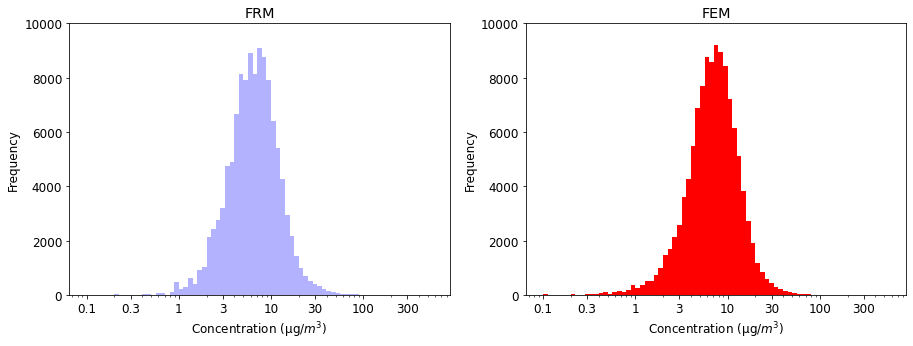

In [25]:
# Histogram of concentrations

bins = 10**np.arange(-1,2.8,0.05)
ticks = [0.1,0.3,1,3,10,30,100,300]
labels=['{}'.format(v) for v in ticks]

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.hist(data=frm_vs_fem,x='arithmetic_mean_a',bins=bins,color='blue',alpha=0.3)
plt.title('FRM')
plt.xscale('log')
plt.xticks(ticks,labels)
plt.ylim([0,10000])
plt.ylabel('Frequency')
plt.xlabel('Concentration (µg/$m^3$)')

plt.subplot(1,2,2)
plt.hist(data=frm_vs_fem,x='arithmetic_mean_b',bins=bins,color='red')
plt.title('FEM')
plt.xscale('log')
plt.xticks(ticks,labels)
plt.ylim([0,10000])
plt.ylabel('Frequency')
plt.xlabel('Concentration (µg/$m^3$)');

#### Histograms both illustrate a log-normal distribution in ambient PM2.5 concentrations, as expected. Similar shapes to both curves. Note the 'hump' on the FRM histogram between 1-3 ug/m3. This is almost certainly due to the precision of the scale, which can only detect mass differences down to a certain level. Different scales will have different limits.

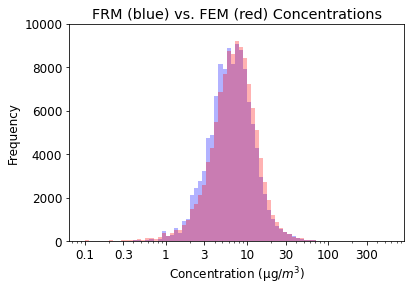

In [26]:
# Same as above, but overlapping.
a=plt.hist(data=frm_vs_fem,x='arithmetic_mean_a',bins=bins,color='blue',alpha=0.3)#, label='FRM')
b=plt.hist(data=frm_vs_fem,x='arithmetic_mean_b',bins=bins,color='red',alpha=0.3)#, label='FEM')
plt.title('FRM (blue) vs. FEM (red) Concentrations')
plt.xscale('log')
plt.xticks(ticks,labels)
plt.ylim([0,10000])
plt.ylabel('Frequency')
plt.xlabel('Concentration (µg/$m^3$)');

#### Plot here illustrates how there is a slight difference between the two distributions, with the FRM to the left.

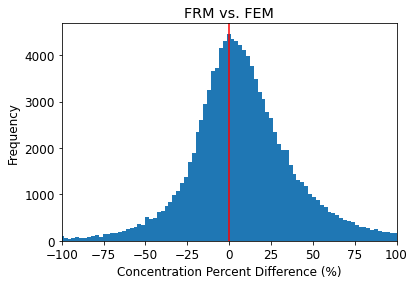

In [27]:
# Histogram of percent differences
plt.hist(data=frm_vs_fem,x='pd',bins=5000)
plt.xlim([-100,100])
plt.axvline(x=0,color='red')
plt.title('FRM vs. FEM')
plt.ylabel('Frequency')
plt.xlabel('Concentration Percent Difference (%)');

#### Percent difference is calculated as (FEM - FRM) / FRM * 100. Therefore, positive (negative) values indicate the FEM concentration is greater (less) than the FRM. While the histogram does peak at zero, note the slight right skew, indicating the FEM is greater than the FRM more often. Again, this is a known bias between these two monitor types.

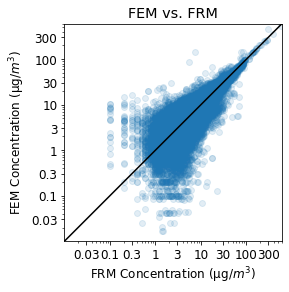

In [28]:
# Scatterplot of FEM (y axis) vs. FRM (x axis)

fig1, ax = plt.subplots()
g = sns.regplot(data=frm_vs_fem,x='arithmetic_mean_a',y='arithmetic_mean_b',scatter_kws={'alpha':1/8},fit_reg=False)
#plt.axis('equal')
ax.set_box_aspect(1)

# Set bins for log-scaling
bins = 10**np.arange(-1,2.8,0.05)
ticks = [0.03,0.1,0.3,1,3,10,30,100,300]
labels=['{}'.format(v) for v in ticks]
plt.xscale('log')
plt.yscale('log')
plt.xticks(ticks,labels)
plt.yticks(ticks,labels)
plt.xlim([0.01,600])
plt.ylim([0.01,600])
plt.title('FEM vs. FRM')
plt.ylabel('FEM Concentration (µg/$m^3$)')
plt.xlabel('FRM Concentration (µg/$m^3$)')

# Draw a line of x=y 
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, 'black');

#### The scatterplot of FEM v FRM concentrations helps illustrate at what concentration levels one method is higher than the other. We see that at lower concentrations (< ~3 ug/m3) the FRM concentrations tend to be higher than the FEM. At higher concentrations (> ~30 ug/m3), there is good agreement between the two as the points are huddled along the 1:1 line. At mid-range concentrations, where the majority of points are seen, the FEM tends to have higher concentrations.

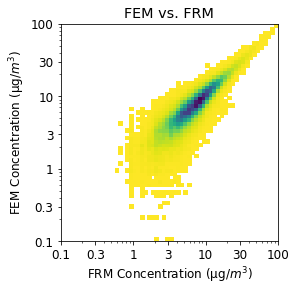

In [29]:
# Too many points in scatterplot above to get a good sense of point cluster in the middle of 'blob'.
# Therefore, let's plot a 2d histogram to get a better idea

# Set bins for log-scaling
bins = 10**np.arange(-1,2.8,0.05)
ticks = [0.03,0.1,0.3,1,3,10,30,100,300]
labels=['{}'.format(v) for v in ticks]

fig1, ax = plt.subplots()
plt.hist2d(data=frm_vs_fem,x='arithmetic_mean_a',y='arithmetic_mean_b',cmin=5,cmap='viridis_r',bins=[bins,bins])
ax.set_box_aspect(1)
plt.xscale('log')
plt.yscale('log')
plt.xticks(ticks,labels)
plt.yticks(ticks,labels)
plt.xlim([0.1,100])
plt.ylim([0.1,100])
plt.title('FEM vs. FRM')
plt.ylabel('FEM Concentration (µg/$m^3$)')
plt.xlabel('FRM Concentration (µg/$m^3$)');

In [30]:
# PD per year summary stats
frm_vs_fem.groupby(frm_vs_fem.date_local.dt.year).pd.describe()

,count,mean,std,min,25%,50%,75%,max
date_local,,,,,,,,
2016,19946.0,15.388090,106.514884,-475.000000,-10.148938,7.186084,29.504514,10000.000
2017,21884.0,8.215095,81.417455,-1382.608500,-13.111006,3.476042,23.684211,8600.000
2018,24597.0,11.633935,126.541844,-537.500000,-10.447761,5.244250,23.690471,10204.167
2019,25762.0,14.436117,96.005901,-528.571000,-7.547170,8.161492,27.286690,8150.000
2020,24469.0,11.964648,96.770688,-509.722167,-8.527132,7.312918,25.635593,7900.000


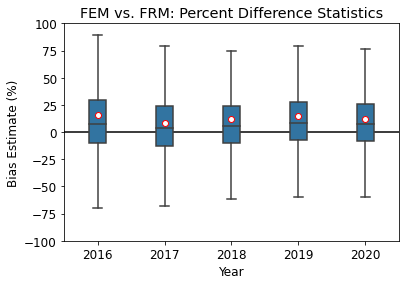

In [31]:
# PD per year box-whisker plot
base_color = sns.color_palette()[0]
sns.boxplot(data=frm_vs_fem,x=frm_vs_fem.date_local.dt.year,y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-100,100])
plt.title('FEM vs. FRM: Percent Difference Statistics')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Year')
plt.axhline(y=0,color='black',zorder=0)

plt.savefig('national_bias_per_year.png', bbox_inches='tight', format='png', dpi=400);

#### We see that a positive bias exists year, w/ the lowest value in 2017. It also appears the variability is slightly decreasing over time, as noted by the reduction in spread of the whiskers (which represent 1.5*IQR)

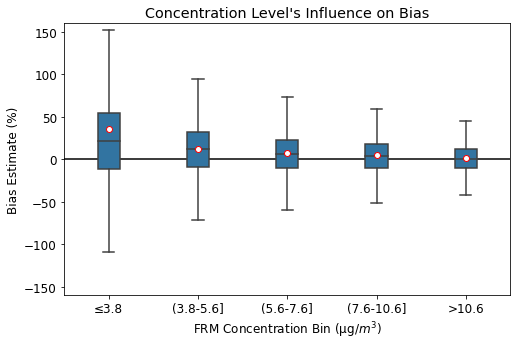

In [32]:
# PD per FRM concentration

# First create a range of concentration values to serve as the bins
bins = frm_vs_fem.arithmetic_mean_a.quantile([0,0.2,0.4,0.6,0.8,1]).values
bin_name = ['≤3.8','(3.8-5.6]','(5.6-7.6]','(7.6-10.6]','>10.6']
frm_vs_fem['frm_conc_bins'] = pd.cut(frm_vs_fem['arithmetic_mean_a'], bins, labels=bin_name)

# Now plot it
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
sns.boxplot(data=frm_vs_fem,x='frm_conc_bins',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color,width=0.25)
plt.ylim([-160,160])
plt.title("Concentration Level's Influence on Bias")
plt.ylabel('Bias Estimate (%)')
plt.xlabel('FRM Concentration Bin (µg/$m^3$)')
plt.axhline(y=0,color='black',zorder=0)
plt.savefig('conc_influence_on_bias.png', bbox_inches='tight', format='png', dpi=400);

#### A clear relationship is seen between bias and concentration in the boxplot above. At higher concentrations, better agreement is seen between the FRM and FEM monitors. At lower concentration, the positive bias is larger, indicating the FEM concentrations are > the FRM.

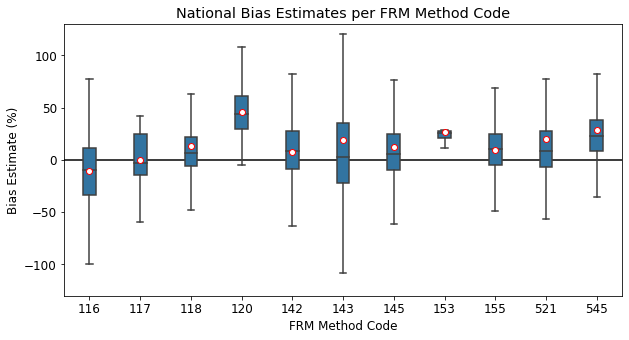

In [33]:
# PD per FRM method code

plt.figure(figsize=[10,5])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=frm_vs_fem,x='method_code_a',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-130,130])
plt.title('National Bias Estimates per FRM Method Code')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('FRM Method Code')
plt.axhline(y=0,color='black',zorder=0);

In [34]:
frm_vs_fem.groupby('method_code_a').pd.describe()

,count,mean,std,min,25%,50%,75%,max
method_code_a,,,,,,,,
116,1414.0,-10.901861,68.864430,-508.333250,-33.395215,-9.798939,11.111111,740.476143
117,15.0,-0.102315,30.275362,-59.420300,-14.808559,-2.777772,25.000000,42.361125
118,2621.0,13.085365,162.166795,-137.037037,-6.086957,6.666667,21.904757,8150.000000
120,276.0,46.265562,24.318383,-37.166680,29.642338,43.953192,61.200777,115.686294
142,4144.0,7.850915,53.584685,-528.571000,-9.036351,8.679509,27.387566,1450.000000
143,5789.0,19.450015,198.057335,-475.000000,-22.222222,2.439024,35.000000,10000.000000
145,99421.0,12.036654,95.207754,-1382.608500,-9.523810,6.092437,25.000000,10204.167000
153,6.0,27.023983,12.726714,11.826923,21.175362,26.178430,27.999691,49.845667
155,934.0,9.361097,35.931665,-163.157895,-4.588594,10.638298,25.000000,533.333333


#### Only method codes 116 and 117 produce an overall negative bias. Method 117, however, only includes 15 data points.

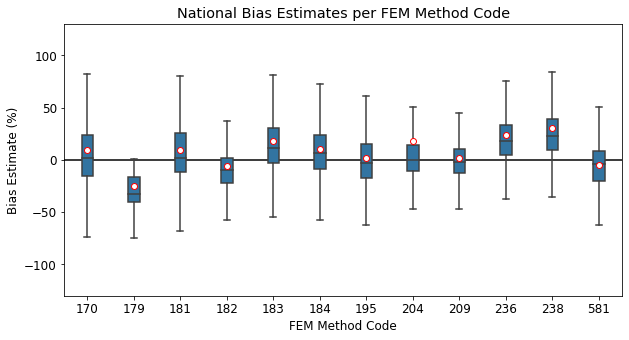

In [35]:
# PD per FEM method code

plt.figure(figsize=[10,5])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=frm_vs_fem,x='method_code_b',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-130,130])
plt.title('National Bias Estimates per FEM Method Code')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('FEM Method Code')
plt.axhline(y=0,color='black',zorder=0);

In [36]:
frm_vs_fem.groupby('method_code_b').pd.describe()

,count,mean,std,min,25%,50%,75%,max
method_code_b,,,,,,,,
170,51234.0,9.309150,91.511262,-1382.608500,-15.043719,2.083333,23.880597,7900.000000
179,12.0,-25.008482,31.108993,-75.000000,-39.831697,-32.456140,-16.269841,52.941176
181,1915.0,9.706202,42.387363,-266.666667,-11.977724,2.000000,26.111108,477.500000
182,3615.0,-6.160493,75.873342,-225.000000,-21.646821,-9.957950,1.977389,3029.166667
183,9223.0,17.780105,40.366447,-110.344828,-3.242634,11.339658,30.701758,911.111111
184,15969.0,10.351685,66.853361,-320.000000,-8.996205,6.779661,23.544968,4958.333500
195,947.0,1.966805,68.136788,-65.671642,-16.895629,-2.857143,14.788338,1950.000000
204,2682.0,18.253461,245.070109,-120.833333,-10.267592,0.000000,14.238496,10000.000000
209,5933.0,1.595003,123.580793,-178.512364,-12.790698,-1.851844,10.232063,8150.000000


#### For the FEM monitors, only method codes 179, 182, and 581 produced a negative bias. Method code 179 had minimal data points (12).

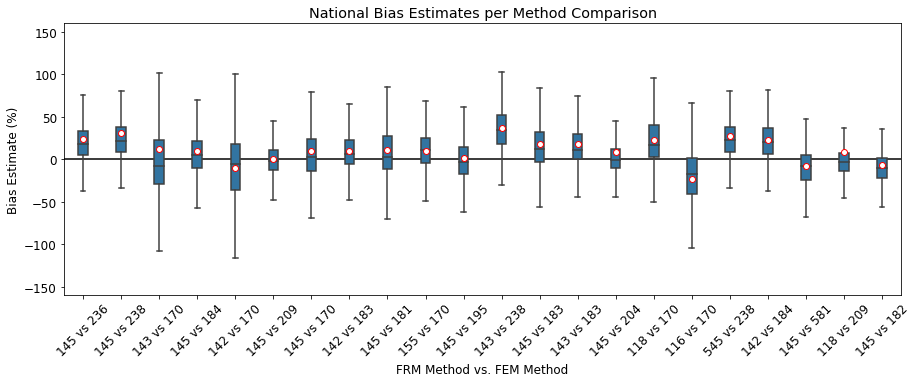

In [37]:
# PD per method type combo

# First create a object column showing the method code comparison, e.g., '116 vs 170'.
frm_vs_fem['meth_vs'] = frm_vs_fem.method_code_a.astype(str) + ' vs ' + frm_vs_fem.method_code_b.astype(str)
frm_vs_fem[['method_code_a','method_code_b','meth_vs']].sample(33)

# There are a lot of method comparisons in the dataset, too many to plot reasonably.
# Therefore, limit the plot to only show when two types occurred over 500 times.
top_occurrences = list(frm_vs_fem.meth_vs.value_counts().index[0:22]) # The top 22 pairs occurred over 500 times in this case
limit_pairs = frm_vs_fem[frm_vs_fem['meth_vs'].isin(top_occurrences)]

# Now plot it
plt.figure(figsize=[15,5])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=limit_pairs,x='meth_vs',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-160,160])
plt.title('National Bias Estimates per Method Comparison')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('FRM Method vs. FEM Method')
plt.axhline(y=0,color='black',zorder=0)
g.set_xticklabels(g.get_xticklabels(),rotation=45);

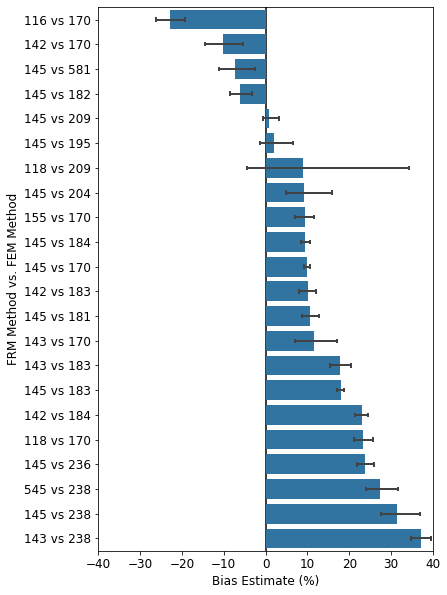

In [38]:
plt.figure(figsize=[6,10])
type_order = limit_pairs.groupby('meth_vs').pd.mean().sort_values().index
sns.barplot(data=limit_pairs,y='meth_vs',x='pd',
            ci=95,errwidth=2,capsize=0.1,color=base_color,order=type_order)
plt.axvline(x=0,color='black',zorder=0)
plt.xlim([-40,40])
plt.xlabel('Bias Estimate (%)')
plt.ylabel('FRM Method vs. FEM Method')
plt.savefig('meth_vs_bias.png', bbox_inches='tight', format='png', dpi=400);

In [39]:
frm_vs_fem.groupby('meth_vs').pd.describe()

,count,mean,std,min,25%,50%,75%,max
meth_vs,,,,,,,,
116 vs 170,1138.0,-22.725060,61.673629,-508.333250,-41.176471,-16.735985,1.758280,383.333333
116 vs 183,276.0,37.847413,75.345468,-71.130929,2.737061,16.279721,39.698617,740.476143
117 vs 170,15.0,-0.102315,30.275362,-59.420300,-14.808559,-2.777772,25.000000,42.361125
118 vs 170,1072.0,23.198180,36.869826,-96.551724,2.651901,17.431141,40.295529,266.129032
118 vs 181,119.0,-5.225683,20.416601,-45.000000,-15.742380,-5.714286,2.298349,109.523810
118 vs 182,213.0,-5.153407,41.883481,-113.384811,-24.627982,-9.426230,10.416667,220.738625
118 vs 183,66.0,12.577669,20.802581,-12.455670,0.647659,9.224265,18.068296,128.333400
118 vs 209,669.0,8.825628,315.897536,-137.037037,-13.953488,-3.409091,7.812500,8150.000000
118 vs 581,482.0,9.156336,14.074983,-58.333333,1.040360,9.090909,17.472826,50.000000


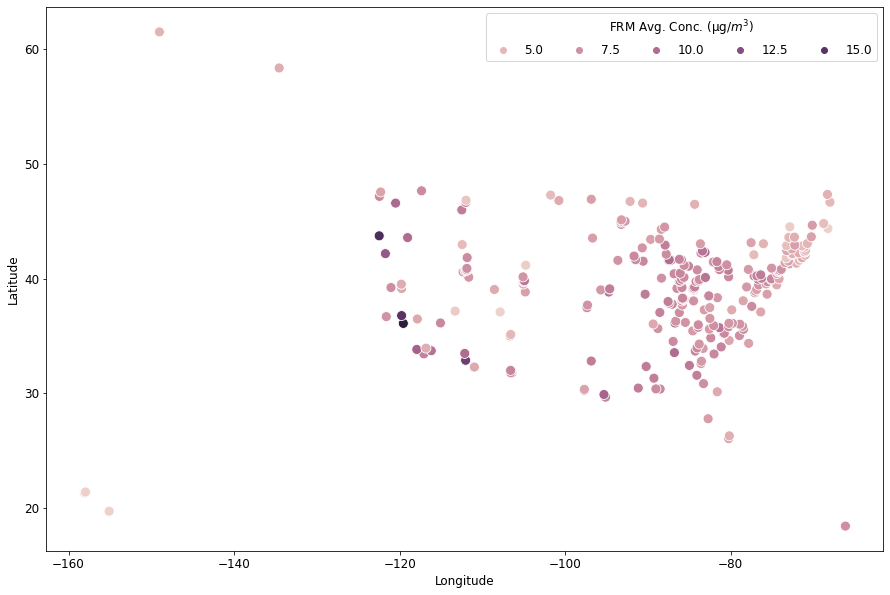

In [40]:
# Avg conc per lat / long
plt.figure(figsize=[15,10])

geo_map_conc = pd.DataFrame(frm_vs_fem.groupby(['latitude_x','longitude_x']).arithmetic_mean_a.mean())
geo_map_conc.reset_index(inplace=True)
geo_map_conc.head()
g = sns.scatterplot(data=geo_map_conc,x='longitude_x',y='latitude_x',s=100,
                hue='arithmetic_mean_a')

L=plt.legend(title='FRM Avg. Conc. (µg/$m^3$)',ncol=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

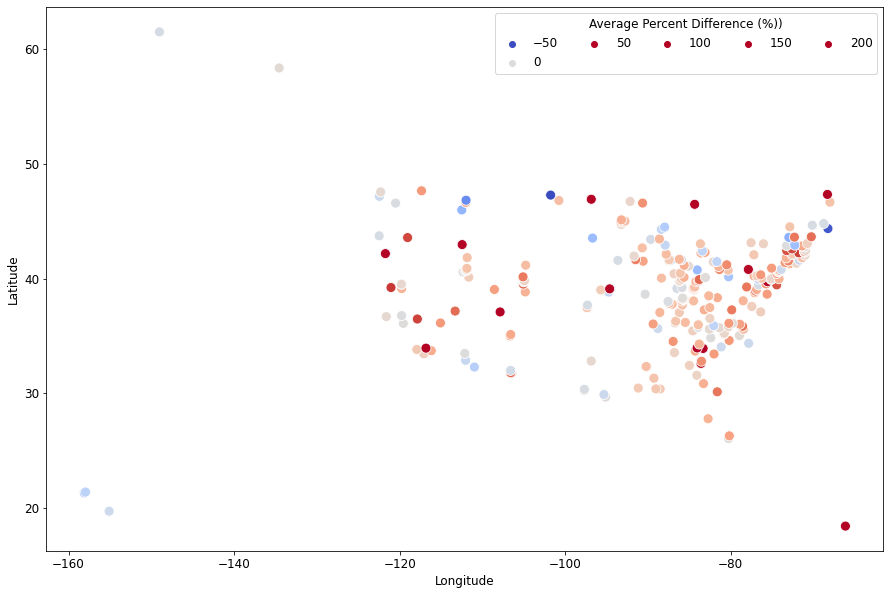

In [41]:
# Avg PD per lat / long
plt.figure(figsize=[15,10])

geo_map_pd = pd.DataFrame(frm_vs_fem.groupby(['latitude_x','longitude_x']).pd.mean())
geo_map_pd.reset_index(inplace=True)
geo_map_pd.head()
g = sns.scatterplot(data=geo_map_pd,x='longitude_x',y='latitude_x',s=100,
                hue='pd',hue_norm=(-50,50),palette="coolwarm")
#sns.color_palette(set_palette("Blues"))
L=plt.legend(title='Average Percent Difference (%))',ncol=5)#, labels=[-50,-25,-5,5,25,50])
plt.xlabel('Longitude')
plt.ylabel('Latitude');

#### Based on the 'map' above, there doesn't appear to be much of a geographical pattern to bias.

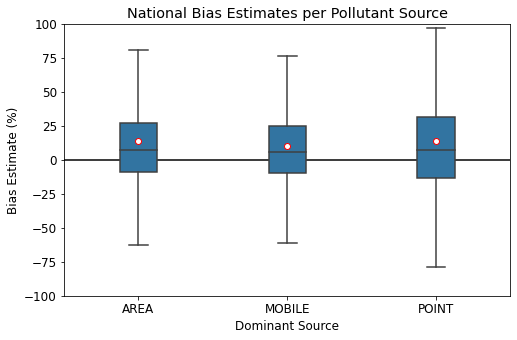

In [43]:
# Quick look at PD vs some categorical variables describing the area.

# Dominant Pollutant Source
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=frm_vs_fem,x='dominant_source',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-100,100])
plt.title('National Bias Estimates per Pollutant Source')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Dominant Source')
plt.axhline(y=0,color='black',zorder=0);
#g.set_xticklabels(g.get_xticklabels(),rotation=45);

In [44]:
frm_vs_fem.groupby('dominant_source').pd.describe()

,count,mean,std,min,25%,50%,75%,max
dominant_source,,,,,,,,
AREA,52341.0,13.917058,111.477688,-1382.608500,-8.730159,7.565789,27.135413,10000.000
MOBILE,7724.0,10.587599,43.642908,-300.000000,-9.565888,6.072060,24.923452,1950.000
POINT,3326.0,13.544383,84.769495,-266.666667,-12.992607,7.221671,31.250000,2727.381


#### Mobile sources produce a lower bias than area and point. Is there statistical significance in the differences?

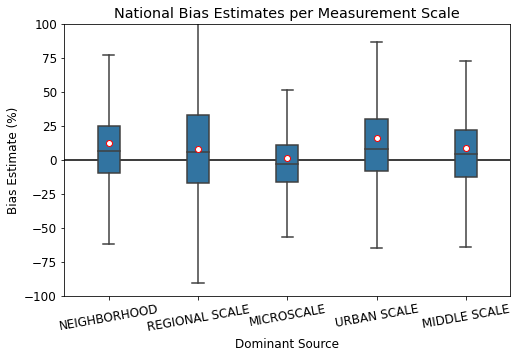

In [45]:
# Measurement Scale
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=frm_vs_fem,x='measurement_scale',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-100,100])
plt.title('National Bias Estimates per Measurement Scale')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Dominant Source')
plt.axhline(y=0,color='black',zorder=0)
g.set_xticklabels(g.get_xticklabels(),rotation=10);

In [46]:
frm_vs_fem.groupby('measurement_scale').pd.describe()

,count,mean,std,min,25%,50%,75%,max
measurement_scale,,,,,,,,
MICROSCALE,1276.0,1.310475,61.350788,-110.344828,-16.378832,-2.823059,11.035835,1950.000000
MIDDLE SCALE,3354.0,8.745363,41.660358,-154.687500,-12.468835,4.166667,21.919222,547.435923
NEIGHBORHOOD,89487.0,12.291177,104.954899,-1382.608500,-9.523810,6.521739,25.287356,10204.167000
REGIONAL SCALE,4605.0,7.897540,63.231615,-1150.000000,-16.666661,5.821074,33.191939,1400.000000
URBAN SCALE,15726.0,16.334161,112.639128,-422.916750,-7.955629,7.888493,30.053614,8150.000000


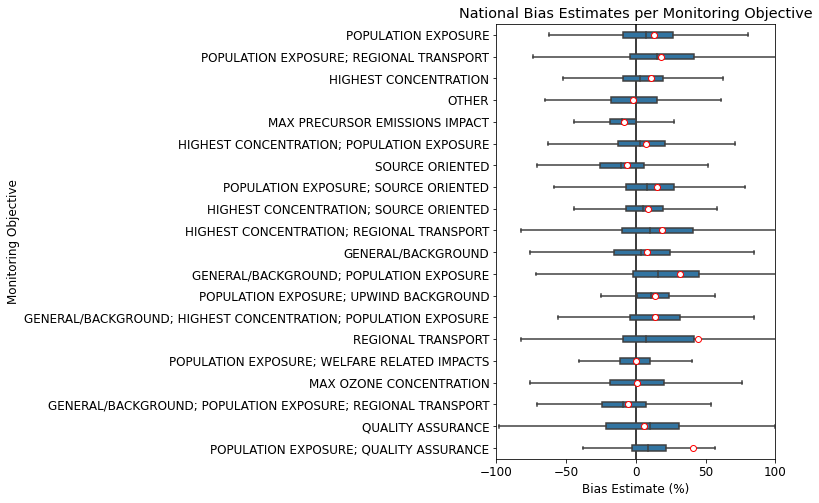

In [48]:
# Monitoring Objective
plt.figure(figsize=[5,8])
base_color = sns.color_palette()[0]
g=sns.boxplot(data=frm_vs_fem,y='monitoring_objective',x='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.xlim([-100,100])
plt.title('National Bias Estimates per Monitoring Objective')
plt.xlabel('Bias Estimate (%)')
plt.ylabel('Monitoring Objective')
plt.axvline(x=0,color='black',zorder=0);
#g.set_xticklabels(g.get_xticklabels(),rotation=10);

In [49]:
frm_vs_fem.groupby('monitoring_objective').pd.describe()

,count,mean,std,min,25%,50%,75%,max
monitoring_objective,,,,,,,,
GENERAL/BACKGROUND,7431.0,7.902509,82.188103,-508.333250,-15.901110,3.869048,24.328822,3128.260750
GENERAL/BACKGROUND; HIGHEST CONCENTRATION; POPULATION EXPOSURE,713.0,13.655428,40.066506,-212.500000,-4.109589,13.636364,31.707317,295.833333
GENERAL/BACKGROUND; POPULATION EXPOSURE,547.0,31.466037,73.944555,-134.722167,-1.912412,15.967017,45.416391,911.111111
GENERAL/BACKGROUND; POPULATION EXPOSURE; REGIONAL TRANSPORT,131.0,-5.305977,48.338161,-131.250000,-24.038462,-8.928571,7.637571,396.666680
HIGHEST CONCENTRATION,2463.0,11.080258,62.898238,-245.833333,-9.409722,2.727273,19.354839,1800.000000
HIGHEST CONCENTRATION; POPULATION EXPOSURE,9252.0,7.619255,59.960812,-334.583300,-12.577286,2.897894,20.927008,2727.381000
HIGHEST CONCENTRATION; REGIONAL TRANSPORT,548.0,18.986976,47.530389,-88.405795,-9.689147,10.027751,41.048056,326.282077
HIGHEST CONCENTRATION; SOURCE ORIENTED,571.0,8.914915,30.481684,-110.344828,-6.704991,5.416660,19.524616,300.833333
MAX OZONE CONCENTRATION,1461.0,0.905916,40.601039,-320.000000,-18.690486,0.000000,19.940464,309.166600


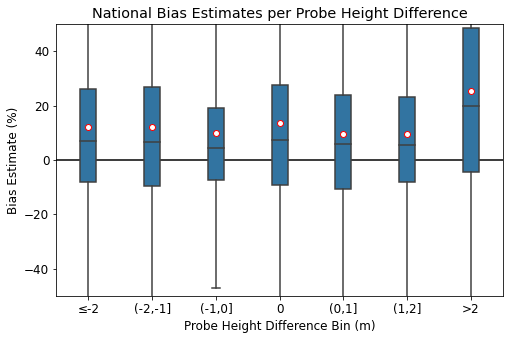

In [50]:
# Look at probe height difference and its relationship w/ PD

# First create a range of hgt_diff values to serve as the bins
bins = [-500,-2,-1,-0.0001,0.0001,1,2,500]
bin_name = ['≤-2','(-2,-1]','(-1,0]','0','(0,1]','(1,2]','>2']
frm_vs_fem['hgt_bin'] = pd.cut(frm_vs_fem['hgt_diff'], bins, labels=bin_name)

# Now plot it
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
sns.boxplot(data=frm_vs_fem,x='hgt_bin',y='pd', fliersize=0, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"},
            color=base_color, width=0.25)
plt.ylim([-160,160])
plt.title('National Bias Estimates per Probe Height Difference')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Probe Height Difference Bin (m)')
plt.axhline(y=0,color='black',zorder=0)
plt.ylim([-50,50]);

In [51]:
frm_vs_fem.groupby('hgt_bin').pd.describe()

,count,mean,std,min,25%,50%,75%,max
hgt_bin,,,,,,,,
≤-2,4764.0,12.003825,79.952375,-288.888889,-8.110998,6.983278,26.218830,4525.000000
"(-2,-1]",13616.0,12.149000,88.887542,-528.571000,-9.658021,6.755901,26.925937,5450.000000
"(-1,0]",6925.0,9.857081,67.859941,-371.428571,-7.539686,4.411765,18.918919,2650.000000
0,54156.0,13.398572,100.515365,-508.333250,-9.357507,7.373516,27.380944,10204.167000
"(0,1]",12432.0,9.659752,113.006143,-509.722167,-10.541549,5.700865,23.809524,8600.000000
"(1,2]",1019.0,9.684732,35.716700,-271.296333,-8.191072,5.555552,23.084648,511.111167
>2,1295.0,25.507305,67.571209,-313.636400,-4.403685,19.761905,48.543074,560.000000


#### Actually have lower pd when probe height difference is greater than zero and less than 1 m than when it is zero... Not until difference is > 2 that we see a big spike in PD.

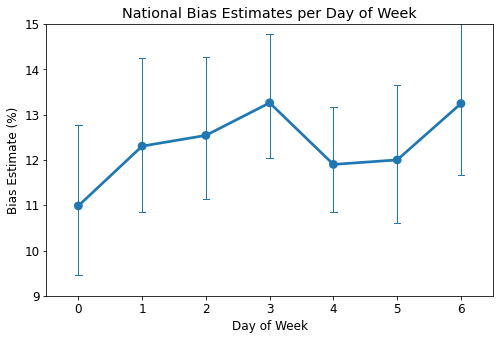

In [52]:
# Day of week
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
sns.pointplot(data=frm_vs_fem,x=frm_vs_fem.date_local.dt.weekday,y='pd',
            ci=95,errwidth=1,capsize=0.1,color=base_color,linewidth=1,edgecolor='black')
plt.ylim([9,15])
plt.title('National Bias Estimates per Day of Week')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Day of Week')
plt.axhline(y=0,color='black',zorder=0);

#### Variability here doesn't look to be significant (all 95% CIs overlap one another).

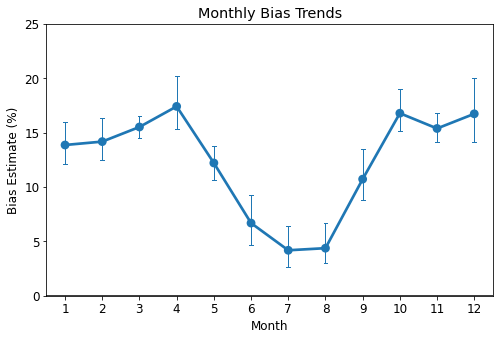

In [53]:
# Time of year

frm_vs_fem['month'] = frm_vs_fem.date_local.dt.month

plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
sns.pointplot(data=frm_vs_fem,x='month',y='pd',
            ci=95,errwidth=1,capsize=0.1,color=base_color,linewidth=1,edgecolor='black')
plt.ylim([0,25])
plt.title('Monthly Bias Trends')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Month')
plt.axhline(y=0,color='black',zorder=0)

plt.savefig('monthly_bias_trends.png', bbox_inches='tight', format='png', dpi=400);

In [54]:
frm_vs_fem.groupby(frm_vs_fem.date_local.dt.month).pd.describe()

,count,mean,std,min,25%,50%,75%,max
date_local,,,,,,,,
1,9748.0,13.871309,103.557095,-509.722167,-10.885039,5.368587,27.162907,7025.000000
2,9142.0,14.182510,101.496248,-528.571000,-9.717259,7.307605,27.576886,6025.000000
3,10039.0,15.528354,53.431924,-1382.608500,-7.777626,11.817328,33.333333,1426.785714
4,9388.0,17.420506,123.492361,-370.000000,-7.504083,11.458335,33.199409,10000.000000
5,9629.0,12.216862,78.643075,-1150.000000,-10.000000,7.303371,27.713186,3128.260750
6,9464.0,6.690514,124.712886,-384.058000,-12.307692,2.751120,19.150476,10204.167000
7,9805.0,4.187557,93.840876,-288.888889,-12.455670,1.190476,16.239316,7200.000000
8,10162.0,4.380315,89.703130,-272.000000,-11.685836,1.724138,16.609568,8150.000000
9,9680.0,10.730587,116.231553,-422.916750,-9.589041,5.169537,23.021711,8354.167000


#### Interesting to see this clear monthly trend, with bias lowest in the Spring and peaks in the hotter summer months. Looks like the weather may be impacting bias. Checking MET data next!

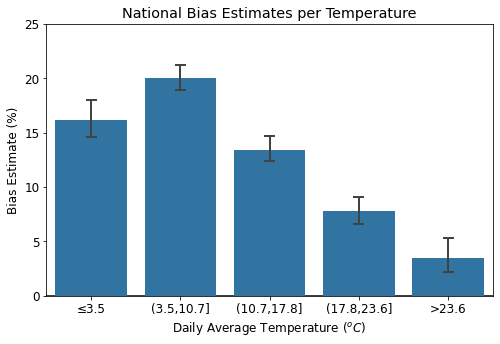

In [55]:
# Explore the MET data relationship w/ PD
# Start w/ temperature.

# First create a range of temperature values to serve as the bins
bins = list(frm_vs_fem.tavg.quantile([0,0.2,0.4,0.6,0.8,1]).values)
bin_name = ['≤3.5','(3.5,10.7]','(10.7,17.8]','(17.8,23.6]','>23.6']
frm_vs_fem['temp_bin'] = pd.cut(frm_vs_fem['tavg'], bins, labels=bin_name)

# Now plot it
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
sns.barplot(data=frm_vs_fem,x='temp_bin',y='pd',
            ci=95,errwidth=2,capsize=0.1,color=base_color)
plt.title('National Bias Estimates per Temperature')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Daily Average Temperature (${^o}C$)')
plt.axhline(y=0,color='black',zorder=0)
plt.ylim([-0,25]);

In [56]:
frm_vs_fem.groupby('temp_bin').pd.describe()

,count,mean,std,min,25%,50%,75%,max
temp_bin,,,,,,,,
≤3.5,20583.0,16.134023,123.754109,-537.50000,-10.200073,6.740975,30.000000,8600.000
"(3.5,10.7]",20760.0,20.074625,80.787125,-1382.60850,-5.704894,13.793103,36.906046,4800.000
"(10.7,17.8]",20383.0,13.452926,84.893109,-422.91675,-9.034907,9.302326,29.242452,7900.000
"(17.8,23.6]",20525.0,7.782006,89.334158,-528.57100,-10.317457,4.866664,20.923913,8354.167
>23.6,20429.0,3.493844,112.306029,-210.83334,-11.197917,1.063830,14.218750,10204.167


#### In agreement w/ the month plot, we see that the bias decreases at higher temperatures. It also appears to decrease at very cold temperatures, peaking somewhere between 3.5 - 10.7 C.

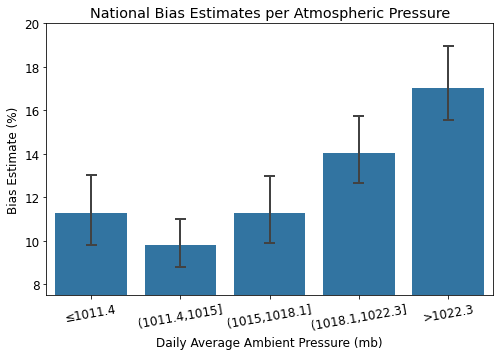

In [57]:
# Pressure

# First create a range of temperature values to serve as the bins
bins = list(frm_vs_fem.pres.quantile([0,0.2,0.4,0.6,0.8,1]).values)
bin_name = ['≤1011.4','(1011.4,1015]','(1015,1018.1]','(1018.1,1022.3]','>1022.3']
frm_vs_fem['pres_bin'] = pd.cut(frm_vs_fem['pres'], bins, labels=bin_name)

# Now plot it
plt.figure(figsize=[8,5])
base_color = sns.color_palette()[0]
g=sns.barplot(data=frm_vs_fem,x='pres_bin',y='pd',
            ci=95,errwidth=2,capsize=0.1,color=base_color)
plt.title('National Bias Estimates per Atmospheric Pressure')
plt.ylabel('Bias Estimate (%)')
plt.xlabel('Daily Average Ambient Pressure (mb)')
plt.axhline(y=0,color='black',zorder=0)
plt.ylim([7.5,20])
g.set_xticklabels(g.get_xticklabels(),rotation=10);

In [58]:
frm_vs_fem.groupby('pres_bin').pd.describe()

,count,mean,std,min,25%,50%,75%,max
pres_bin,,,,,,,,
≤1011.4,17730.0,11.294075,111.272916,-528.571000,-11.764706,5.663312,26.190475,10204.167
"(1011.4,1015]",17355.0,9.791370,75.343446,-509.722167,-10.344828,4.761905,23.164212,5450.000
"(1015,1018.1]",16309.0,11.273321,102.423271,-1382.608500,-8.695652,6.185567,23.646726,8150.000
"(1018.1,1022.3]",17784.0,14.051650,105.866752,-405.555500,-7.428760,7.937849,26.311092,8354.167
>1022.3,17285.0,17.007499,112.556637,-537.500000,-6.666667,10.112360,30.188679,8600.000


#### See higher bias at higher pressures. However, correlation doesn't necessarily = causation. This signal could just be due to pressures generally being higher in the winter since cold air is denser than warm air (i.e., this may just be a signal from temperature). Can't rule out pressure actually having an impact though. Let's therefore look at a multivariate heatmap: Mean PD per temp and pressure bins

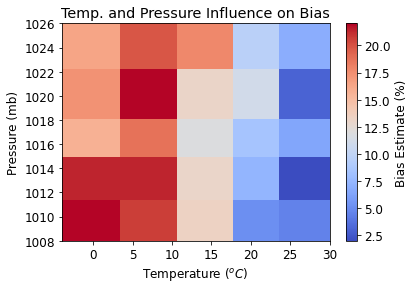

In [59]:
# 2D histogram: Mean PD illustrated in temp v pres bins

xbin_edges = list(frm_vs_fem.tavg.quantile([0,0.2,0.4,0.6,0.8,1]).values)
xbin_edges[-1] = xbin_edges[-1]+1
ybin_edges = list(frm_vs_fem.pres.quantile([0,0.2,0.4,0.6,0.8,1]).values)
ybin_edges[-1] = ybin_edges[-1]+1

# Remove rows w/ NaNs
df_hst = frm_vs_fem[['pd','tavg','pres']].copy()
df_hst.reset_index(inplace=True)
df_hst.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hst.dropna(axis=0, how='any',inplace=True)

# count number of points in each bin
xbin_idxs = pd.cut(df_hst.tavg,xbin_edges,right=False,include_lowest=True,labels=False).astype(int)
ybin_idxs = pd.cut(df_hst.pres,ybin_edges,right=False,include_lowest=True,labels=False).astype(int)

pts_per_bin = df_hst.groupby([xbin_idxs,ybin_idxs]).size()
pts_per_bin = pts_per_bin.reset_index()
pts_per_bin = pts_per_bin.pivot(index='tavg',columns='pres').values

z_wts = df_hst.pd / pts_per_bin[xbin_idxs, ybin_idxs]

# plot the data
plt.hist2d(data=df_hst,x='tavg',y='pres',weights=z_wts,
           bins=[xbin_edges,ybin_edges],cmap='coolwarm',cmin=0.5)
plt.title('Temp. and Pressure Influence on Bias')
plt.xlabel('Temperature (${^o}C$)')
plt.ylabel('Pressure (mb)')
plt.colorbar(label='Bias Estimate (%)')
plt.xlim([-4,30])
plt.ylim([1008,1026])

plt.savefig('temp_press_bias.png', bbox_inches='tight', format='png', dpi=400);

#### The 2D heat map above shows that the influence of temperature on bias is greater than that from pressure, but both parameters do have an impact. Bias clearly decreases w/ increasing temperature no matter the pressure. It appears that the bias increases more drastically w/ increasing temperature when the pressure value is smaller as compared to when it is larger. In other words the largest (smallest) bias exists when the pressure is low and temperature is low (high).

# Implement:
## a ML model to predict the FRM concentration given the FEM concentration. Factors used in the model will include:
1. FEM concentration,
2. Probe Height difference,
3. Month of measurement,
4. Method Code (from both separately or just combined?)
5. Meteorological data (temperature, pressure, etc.)
6. Location (AQS ID)

Predicting FRM rather than FEM b/c FEM concentration results are available almost immediately, whereas FRM concentrations typically are not available for many weeks.

In [65]:
#Create dataframe of all predicting variables and one for what we are predicting
model_data = frm_vs_fem[['arithmetic_mean_a','arithmetic_mean_b','hgt_diff','month','meth_vs','tavg','prcp','wspd','pres']]
print(model_data.shape)
# Drop any row w/ NaN value
model_data=model_data.dropna(axis=0,how='any')
model_data.shape

(116712, 9)


(62827, 9)

#### Dropping rows w/ NaNs nearly cuts the dataset in half: from 116,712 to 62,827 rows.

In [66]:
# Predict FRM concentration using various parameters
# Create separate dataframes of all predicting variables and predicted
X = model_data[['arithmetic_mean_b','hgt_diff','month','meth_vs','tavg','prcp','wspd','pres']]
Y = model_data['arithmetic_mean_a']

# Create dummy variables for the meth_vs column, dropping the first, as it can be implied from the others.
meth_dummies = pd.get_dummies(X.meth_vs,drop_first=True)

# Concatenate to X, and drop the original meth_vs object column
X = pd.concat([X,meth_dummies],axis=1)
X = X.drop(columns='meth_vs')
X.columns = X.columns.str.replace(' ','_')

# Split into training and test datasets
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

# Instantiate the model
lm_model = LinearRegression(normalize=True)

# Fit training
lm_model.fit(x_train, y_train)

# Predict
y_test_preds = lm_model.predict(x_test)

# Score
print('The r2 score from the model prediction on the test data is: {}.'.format(r2_score(y_test,y_test_preds)))
print('The mean squared error from the model prediction on the test data is: {}.'.format(mean_squared_error(y_test,y_test_preds)))

The r2 score from the model prediction on the test data is: 0.868818334863785.
The mean squared error from the model prediction on the test data is: 4.0700691382224035.


In [106]:
# To demonstrate that the optimized model is robust, here we'll perform a time-series k-fold
# cross validation. How the model performs across each individual validation fold will help answer.
# If the validation performance is stable and doesn't fluctuate much, then we can
# argue that the model is robust against small perturbations in the training data.

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5,test_size=1000,gap=0)
print(tscv)

mdl_dat = model_data.copy()
mdl_dat = mdl_dat.sample(frac=1)

X = mdl_dat[['arithmetic_mean_b','hgt_diff','month','meth_vs','tavg','prcp','wspd','pres']]
Y = mdl_dat['arithmetic_mean_a']

# Create dummy variables for the meth_vs column, dropping the first, as it can be implied from the others.
meth_dummies = pd.get_dummies(X.meth_vs,drop_first=True)

# Concatenate to X, and drop the original meth_vs object column
X = pd.concat([X,meth_dummies],axis=1)
X = X.drop(columns='meth_vs')
X.columns = X.columns.str.replace(' ','_')

# Convert dataframes to series
X = np.array(X)
Y = np.array(Y)

# Time-series k-fold cross validation of model results
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Instantiate the model
    lm_model = LinearRegression(normalize=True)

    # Fit training
    lm_model.fit(x_train, y_train)

    # Predict
    y_test_preds = lm_model.predict(x_test)

    # Score
    print('The r2 score from the model prediction on the test data is: {}.'.format(r2_score(y_test,y_test_preds)))
    print('The mean squared error from the model prediction on the test data is: {}.'.format(mean_squared_error(y_test,y_test_preds)))
    

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=1000)
The r2 score from the model prediction on the test data is: 0.8634350917838614.
The mean squared error from the model prediction on the test data is: 4.125374377908929.
The r2 score from the model prediction on the test data is: 0.8652664825929588.
The mean squared error from the model prediction on the test data is: 4.418129461990596.
The r2 score from the model prediction on the test data is: 0.8678642278804607.
The mean squared error from the model prediction on the test data is: 3.3988904692682804.
The r2 score from the model prediction on the test data is: 0.8691996045105415.
The mean squared error from the model prediction on the test data is: 3.5252309883336843.
The r2 score from the model prediction on the test data is: 0.8843953222965066.
The mean squared error from the model prediction on the test data is: 3.699691210474847.


In [139]:
# Is this better than just assuming the FRM = FEM?
print('The r2 score if assuming the FRM is simply equal to the FEM is: {}.'.format(r2_score(y_test,x_test.arithmetic_mean_b)))
print('The mean squared error assuming the same is: {}.'.format(mean_squared_error(y_test,x_test.arithmetic_mean_b)))

The r2 score if assuming the FRM is simply equal to the FEM is: 0.858946978962766.
The mean squared error assuming the same is: 5.273768961235801.


#### We do predict slightly better from the model than just assuming FRM = FEM.

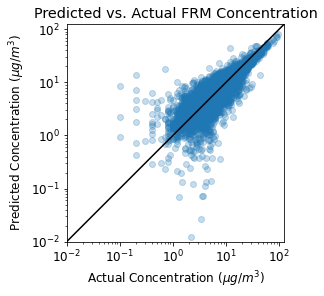

In [141]:
# Plot the predicted vs actual FRM concentrations
# Scatterplot of FEM (y axis) vs. FRM (x axis)

fig1, ax = plt.subplots()
base_color = sns.color_palette()[0]
g = sns.regplot(x=y_test,y=y_test_preds,scatter_kws={'alpha':1/4},fit_reg=False,color=base_color)
#plt.axis('equal')
ax.set_box_aspect(1)

plt.xlim([0.01,125])
plt.ylim([0.01,125])
plt.xscale('log')
plt.yscale('log')

plt.title('Predicted vs. Actual FRM Concentration')
plt.ylabel('Predicted Concentration ($µg/m^3$)')
plt.xlabel('Actual Concentration ($µg/m^3$)')

# Draw a line of x=y 
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, 'black')

plt.savefig('pred_vs_actual_FRM.png', bbox_inches='tight', format='png', dpi=400);

In [459]:
# Can use the results of this model to now predict with single set of predictor values
# e.g.
lm_model.predict(np.array(x_test.loc[104524,:]).reshape(1, -1))[0]

6.279248258282634

#### Conclusion

>A known bias exists between FRM and FEM PM2.5 monitor concentrations. Herein, we showed that there are various parameters influencing this bias, and we have created a model that can, with relatively good accuracy, predict the FRM concentration from the FEM concentration and other factors